In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_1_coords_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(772408, 831)
(772408, 8)
validation
(101248, 831)
(101248, 8)
test
(98888, 831)
(98888, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 831)]             0         


 dense (Dense)               (None, 1024)              851968    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1542024 (5.88 MB)


Trainable params: 1542024 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/78 [..............................] - ETA: 1:36 - loss: 2.5507 - STD: 0.1037 - MAE: 0.2269

 5/78 [>.............................] - ETA: 1s - loss: 1.7944 - STD: 0.1100 - MAE: 0.1921  

 8/78 [==>...........................] - ETA: 1s - loss: 1.6252 - STD: 0.1520 - MAE: 0.1702

12/78 [===>..........................] - ETA: 1s - loss: 1.5392 - STD: 0.1797 - MAE: 0.1565

16/78 [=====>........................] - ETA: 1s - loss: 1.4942 - STD: 0.1862 - MAE: 0.1525

20/78 [======>.......................] - ETA: 0s - loss: 1.4670 - STD: 0.1871 - MAE: 0.1512

24/78 [========>.....................] - ETA: 0s - loss: 1.4438 - STD: 0.1891 - MAE: 0.1497

28/78 [=========>....................] - ETA: 0s - loss: 1.4288 - STD: 0.1915 - MAE: 0.1484

32/78 [===========>..................] - ETA: 0s - loss: 1.4153 - STD: 0.1924 - MAE: 0.1477

36/78 [============>.................] - ETA: 0s - loss: 1.4051 - STD: 0.1916 - MAE: 0.1477

38/78 [=============>................] - ETA: 1s - loss: 1.4020 - STD: 0.1911 - MAE: 0.1478

42/78 [===============>..............] - ETA: 1s - loss: 1.3946 - STD: 0.1904 - MAE: 0.1479

46/78 [================>.............] - ETA: 0s - loss: 1.3881 - STD: 0.1904 - MAE: 0.1477

50/78 [==================>...........] - ETA: 0s - loss: 1.3827 - STD: 0.1907 - MAE: 0.1475

54/78 [===================>..........] - ETA: 0s - loss: 1.3778 - STD: 0.1907 - MAE: 0.1473

58/78 [=====================>........] - ETA: 0s - loss: 1.3735 - STD: 0.1907 - MAE: 0.1472

62/78 [======================>.......] - ETA: 0s - loss: 1.3692 - STD: 0.1907 - MAE: 0.1471

66/78 [========================>.....] - ETA: 0s - loss: 1.3661 - STD: 0.1909 - MAE: 0.1469

70/78 [=========================>....] - ETA: 0s - loss: 1.3629 - STD: 0.1910 - MAE: 0.1468

74/78 [===========================>..] - ETA: 0s - loss: 1.3603 - STD: 0.1911 - MAE: 0.1467

78/78 [==============================] - ETA: 0s - loss: 1.3581 - STD: 0.1911 - MAE: 0.1467

78/78 [==============================] - 4s 32ms/step - loss: 1.3581 - STD: 0.1911 - MAE: 0.1467 - val_loss: 1.2742 - val_STD: 0.1903 - val_MAE: 0.1455


Epoch 2/10000


 1/78 [..............................] - ETA: 3s - loss: 1.3243 - STD: 0.1904 - MAE: 0.1464

 3/78 [>.............................] - ETA: 1s - loss: 1.3122 - STD: 0.1900 - MAE: 0.1459

 7/78 [=>............................] - ETA: 1s - loss: 1.3162 - STD: 0.1903 - MAE: 0.1459

11/78 [===>..........................] - ETA: 1s - loss: 1.3164 - STD: 0.1909 - MAE: 0.1458

15/78 [====>.........................] - ETA: 1s - loss: 1.3174 - STD: 0.1910 - MAE: 0.1457

19/78 [======>.......................] - ETA: 0s - loss: 1.3188 - STD: 0.1909 - MAE: 0.1458

22/78 [=======>......................] - ETA: 0s - loss: 1.3177 - STD: 0.1909 - MAE: 0.1458

26/78 [=========>....................] - ETA: 0s - loss: 1.3162 - STD: 0.1913 - MAE: 0.1455

30/78 [==========>...................] - ETA: 0s - loss: 1.3172 - STD: 0.1913 - MAE: 0.1456

34/78 [============>.................] - ETA: 0s - loss: 1.3160 - STD: 0.1910 - MAE: 0.1456

38/78 [=============>................] - ETA: 0s - loss: 1.3164 - STD: 0.1912 - MAE: 0.1456

42/78 [===============>..............] - ETA: 0s - loss: 1.3168 - STD: 0.1913 - MAE: 0.1455

46/78 [================>.............] - ETA: 0s - loss: 1.3166 - STD: 0.1912 - MAE: 0.1456

50/78 [==================>...........] - ETA: 0s - loss: 1.3160 - STD: 0.1912 - MAE: 0.1455

54/78 [===================>..........] - ETA: 0s - loss: 1.3157 - STD: 0.1913 - MAE: 0.1454

58/78 [=====================>........] - ETA: 0s - loss: 1.3147 - STD: 0.1913 - MAE: 0.1454

62/78 [======================>.......] - ETA: 0s - loss: 1.3145 - STD: 0.1913 - MAE: 0.1454

66/78 [========================>.....] - ETA: 0s - loss: 1.3139 - STD: 0.1914 - MAE: 0.1453

69/78 [=========================>....] - ETA: 0s - loss: 1.3133 - STD: 0.1914 - MAE: 0.1452

73/78 [===========================>..] - ETA: 0s - loss: 1.3128 - STD: 0.1914 - MAE: 0.1452

77/78 [============================>.] - ETA: 0s - loss: 1.3120 - STD: 0.1913 - MAE: 0.1452

78/78 [==============================] - 1s 18ms/step - loss: 1.3116 - STD: 0.1913 - MAE: 0.1452 - val_loss: 1.2508 - val_STD: 0.1898 - val_MAE: 0.1442


Epoch 3/10000


 1/78 [..............................] - ETA: 3s - loss: 1.2868 - STD: 0.1909 - MAE: 0.1440

 5/78 [>.............................] - ETA: 1s - loss: 1.2800 - STD: 0.1943 - MAE: 0.1424

 9/78 [==>...........................] - ETA: 1s - loss: 1.2856 - STD: 0.1934 - MAE: 0.1430

13/78 [====>.........................] - ETA: 1s - loss: 1.2830 - STD: 0.1931 - MAE: 0.1430

17/78 [=====>........................] - ETA: 0s - loss: 1.2810 - STD: 0.1932 - MAE: 0.1430

21/78 [=======>......................] - ETA: 0s - loss: 1.2798 - STD: 0.1931 - MAE: 0.1430

25/78 [========>.....................] - ETA: 0s - loss: 1.2771 - STD: 0.1933 - MAE: 0.1429

29/78 [==========>...................] - ETA: 0s - loss: 1.2719 - STD: 0.1939 - MAE: 0.1424

33/78 [===========>..................] - ETA: 0s - loss: 1.2675 - STD: 0.1946 - MAE: 0.1420

37/78 [=============>................] - ETA: 0s - loss: 1.2628 - STD: 0.1949 - MAE: 0.1418

41/78 [==============>...............] - ETA: 0s - loss: 1.2589 - STD: 0.1953 - MAE: 0.1415

45/78 [================>.............] - ETA: 0s - loss: 1.2545 - STD: 0.1955 - MAE: 0.1413

49/78 [=================>............] - ETA: 0s - loss: 1.2502 - STD: 0.1958 - MAE: 0.1411

53/78 [===================>..........] - ETA: 0s - loss: 1.2458 - STD: 0.1962 - MAE: 0.1408

56/78 [====================>.........] - ETA: 0s - loss: 1.2430 - STD: 0.1964 - MAE: 0.1407

60/78 [======================>.......] - ETA: 0s - loss: 1.2396 - STD: 0.1966 - MAE: 0.1405

64/78 [=======================>......] - ETA: 0s - loss: 1.2363 - STD: 0.1969 - MAE: 0.1403

68/78 [=========================>....] - ETA: 0s - loss: 1.2322 - STD: 0.1972 - MAE: 0.1401

72/78 [==========================>...] - ETA: 0s - loss: 1.2282 - STD: 0.1973 - MAE: 0.1399

76/78 [============================>.] - ETA: 0s - loss: 1.2253 - STD: 0.1976 - MAE: 0.1398

78/78 [==============================] - 1s 18ms/step - loss: 1.2236 - STD: 0.1977 - MAE: 0.1397 - val_loss: 1.1476 - val_STD: 0.2020 - val_MAE: 0.1376


Epoch 4/10000


 1/78 [..............................] - ETA: 3s - loss: 1.1638 - STD: 0.2003 - MAE: 0.1377

 5/78 [>.............................] - ETA: 1s - loss: 1.1533 - STD: 0.2001 - MAE: 0.1373

 9/78 [==>...........................] - ETA: 1s - loss: 1.1547 - STD: 0.2005 - MAE: 0.1372

13/78 [====>.........................] - ETA: 1s - loss: 1.1502 - STD: 0.2009 - MAE: 0.1369

17/78 [=====>........................] - ETA: 0s - loss: 1.1487 - STD: 0.2014 - MAE: 0.1367

21/78 [=======>......................] - ETA: 0s - loss: 1.1476 - STD: 0.2015 - MAE: 0.1366

24/78 [========>.....................] - ETA: 0s - loss: 1.1462 - STD: 0.2013 - MAE: 0.1367

28/78 [=========>....................] - ETA: 0s - loss: 1.1440 - STD: 0.2013 - MAE: 0.1367

32/78 [===========>..................] - ETA: 0s - loss: 1.1424 - STD: 0.2013 - MAE: 0.1366

36/78 [============>.................] - ETA: 0s - loss: 1.1400 - STD: 0.2013 - MAE: 0.1366

40/78 [==============>...............] - ETA: 0s - loss: 1.1372 - STD: 0.2016 - MAE: 0.1364

44/78 [===============>..............] - ETA: 0s - loss: 1.1341 - STD: 0.2017 - MAE: 0.1362

48/78 [=================>............] - ETA: 0s - loss: 1.1318 - STD: 0.2016 - MAE: 0.1362

52/78 [===================>..........] - ETA: 0s - loss: 1.1294 - STD: 0.2018 - MAE: 0.1361

56/78 [====================>.........] - ETA: 0s - loss: 1.1269 - STD: 0.2018 - MAE: 0.1360

60/78 [======================>.......] - ETA: 0s - loss: 1.1246 - STD: 0.2019 - MAE: 0.1359

64/78 [=======================>......] - ETA: 0s - loss: 1.1217 - STD: 0.2021 - MAE: 0.1357

68/78 [=========================>....] - ETA: 0s - loss: 1.1194 - STD: 0.2023 - MAE: 0.1355

72/78 [==========================>...] - ETA: 0s - loss: 1.1176 - STD: 0.2023 - MAE: 0.1355

76/78 [============================>.] - ETA: 0s - loss: 1.1147 - STD: 0.2025 - MAE: 0.1352

78/78 [==============================] - 1s 18ms/step - loss: 1.1132 - STD: 0.2026 - MAE: 0.1352 - val_loss: 1.0481 - val_STD: 0.2091 - val_MAE: 0.1304


Epoch 5/10000


 1/78 [..............................] - ETA: 3s - loss: 1.0466 - STD: 0.2095 - MAE: 0.1293

 5/78 [>.............................] - ETA: 1s - loss: 1.0477 - STD: 0.2078 - MAE: 0.1301

 9/78 [==>...........................] - ETA: 1s - loss: 1.0459 - STD: 0.2080 - MAE: 0.1300

13/78 [====>.........................] - ETA: 0s - loss: 1.0473 - STD: 0.2077 - MAE: 0.1302

17/78 [=====>........................] - ETA: 0s - loss: 1.0449 - STD: 0.2078 - MAE: 0.1301

21/78 [=======>......................] - ETA: 0s - loss: 1.0430 - STD: 0.2078 - MAE: 0.1301

25/78 [========>.....................] - ETA: 0s - loss: 1.0413 - STD: 0.2081 - MAE: 0.1298

29/78 [==========>...................] - ETA: 0s - loss: 1.0373 - STD: 0.2085 - MAE: 0.1296

33/78 [===========>..................] - ETA: 0s - loss: 1.0338 - STD: 0.2089 - MAE: 0.1292

37/78 [=============>................] - ETA: 0s - loss: 1.0311 - STD: 0.2090 - MAE: 0.1291

41/78 [==============>...............] - ETA: 0s - loss: 1.0282 - STD: 0.2093 - MAE: 0.1288

45/78 [================>.............] - ETA: 0s - loss: 1.0250 - STD: 0.2096 - MAE: 0.1286

49/78 [=================>............] - ETA: 0s - loss: 1.0220 - STD: 0.2099 - MAE: 0.1283

53/78 [===================>..........] - ETA: 0s - loss: 1.0183 - STD: 0.2102 - MAE: 0.1280

57/78 [====================>.........] - ETA: 0s - loss: 1.0154 - STD: 0.2105 - MAE: 0.1277

61/78 [======================>.......] - ETA: 0s - loss: 1.0120 - STD: 0.2108 - MAE: 0.1275

65/78 [========================>.....] - ETA: 0s - loss: 1.0087 - STD: 0.2112 - MAE: 0.1272

69/78 [=========================>....] - ETA: 0s - loss: 1.0051 - STD: 0.2116 - MAE: 0.1268

73/78 [===========================>..] - ETA: 0s - loss: 1.0017 - STD: 0.2119 - MAE: 0.1266

77/78 [============================>.] - ETA: 0s - loss: 0.9985 - STD: 0.2124 - MAE: 0.1262

78/78 [==============================] - 1s 18ms/step - loss: 0.9976 - STD: 0.2125 - MAE: 0.1261 - val_loss: 0.9401 - val_STD: 0.2072 - val_MAE: 0.1259


Epoch 6/10000


 1/78 [..............................] - ETA: 3s - loss: 0.9372 - STD: 0.2083 - MAE: 0.1253

 4/78 [>.............................] - ETA: 1s - loss: 0.9259 - STD: 0.2186 - MAE: 0.1200

 8/78 [==>...........................] - ETA: 1s - loss: 0.9267 - STD: 0.2198 - MAE: 0.1196

12/78 [===>..........................] - ETA: 1s - loss: 0.9242 - STD: 0.2209 - MAE: 0.1190

16/78 [=====>........................] - ETA: 0s - loss: 0.9235 - STD: 0.2209 - MAE: 0.1190

20/78 [======>.......................] - ETA: 0s - loss: 0.9226 - STD: 0.2208 - MAE: 0.1191

24/78 [========>.....................] - ETA: 0s - loss: 0.9213 - STD: 0.2210 - MAE: 0.1188

28/78 [=========>....................] - ETA: 0s - loss: 0.9193 - STD: 0.2214 - MAE: 0.1186

32/78 [===========>..................] - ETA: 0s - loss: 0.9181 - STD: 0.2217 - MAE: 0.1184

36/78 [============>.................] - ETA: 0s - loss: 0.9166 - STD: 0.2219 - MAE: 0.1182

40/78 [==============>...............] - ETA: 0s - loss: 0.9144 - STD: 0.2223 - MAE: 0.1179

44/78 [===============>..............] - ETA: 0s - loss: 0.9126 - STD: 0.2226 - MAE: 0.1177

48/78 [=================>............] - ETA: 0s - loss: 0.9118 - STD: 0.2228 - MAE: 0.1176

52/78 [===================>..........] - ETA: 0s - loss: 0.9107 - STD: 0.2229 - MAE: 0.1175

56/78 [====================>.........] - ETA: 0s - loss: 0.9100 - STD: 0.2231 - MAE: 0.1174

60/78 [======================>.......] - ETA: 0s - loss: 0.9093 - STD: 0.2233 - MAE: 0.1173

64/78 [=======================>......] - ETA: 0s - loss: 0.9081 - STD: 0.2235 - MAE: 0.1171

68/78 [=========================>....] - ETA: 0s - loss: 0.9074 - STD: 0.2236 - MAE: 0.1170

72/78 [==========================>...] - ETA: 0s - loss: 0.9063 - STD: 0.2238 - MAE: 0.1169

76/78 [============================>.] - ETA: 0s - loss: 0.9052 - STD: 0.2239 - MAE: 0.1168

78/78 [==============================] - 1s 18ms/step - loss: 0.9049 - STD: 0.2240 - MAE: 0.1167 - val_loss: 0.8836 - val_STD: 0.2243 - val_MAE: 0.1156


Epoch 7/10000


 1/78 [..............................] - ETA: 4s - loss: 0.8851 - STD: 0.2274 - MAE: 0.1142

 4/78 [>.............................] - ETA: 1s - loss: 0.8834 - STD: 0.2267 - MAE: 0.1143

 8/78 [==>...........................] - ETA: 1s - loss: 0.8807 - STD: 0.2264 - MAE: 0.1144

12/78 [===>..........................] - ETA: 1s - loss: 0.8774 - STD: 0.2271 - MAE: 0.1139

16/78 [=====>........................] - ETA: 0s - loss: 0.8769 - STD: 0.2275 - MAE: 0.1137

20/78 [======>.......................] - ETA: 0s - loss: 0.8754 - STD: 0.2279 - MAE: 0.1135

24/78 [========>.....................] - ETA: 0s - loss: 0.8762 - STD: 0.2279 - MAE: 0.1135

28/78 [=========>....................] - ETA: 0s - loss: 0.8765 - STD: 0.2279 - MAE: 0.1136

32/78 [===========>..................] - ETA: 0s - loss: 0.8757 - STD: 0.2280 - MAE: 0.1135

36/78 [============>.................] - ETA: 0s - loss: 0.8752 - STD: 0.2279 - MAE: 0.1135

40/78 [==============>...............] - ETA: 0s - loss: 0.8744 - STD: 0.2281 - MAE: 0.1133

44/78 [===============>..............] - ETA: 0s - loss: 0.8737 - STD: 0.2282 - MAE: 0.1132

48/78 [=================>............] - ETA: 0s - loss: 0.8737 - STD: 0.2282 - MAE: 0.1133

52/78 [===================>..........] - ETA: 0s - loss: 0.8727 - STD: 0.2284 - MAE: 0.1131

55/78 [====================>.........] - ETA: 0s - loss: 0.8722 - STD: 0.2285 - MAE: 0.1130

59/78 [=====================>........] - ETA: 0s - loss: 0.8714 - STD: 0.2285 - MAE: 0.1130

63/78 [=======================>......] - ETA: 0s - loss: 0.8709 - STD: 0.2286 - MAE: 0.1130

67/78 [========================>.....] - ETA: 0s - loss: 0.8700 - STD: 0.2288 - MAE: 0.1128

70/78 [=========================>....] - ETA: 0s - loss: 0.8698 - STD: 0.2288 - MAE: 0.1128

74/78 [===========================>..] - ETA: 0s - loss: 0.8699 - STD: 0.2288 - MAE: 0.1128

78/78 [==============================] - ETA: 0s - loss: 0.8699 - STD: 0.2290 - MAE: 0.1127

78/78 [==============================] - 1s 18ms/step - loss: 0.8699 - STD: 0.2290 - MAE: 0.1127 - val_loss: 0.8724 - val_STD: 0.2328 - val_MAE: 0.1108


Epoch 8/10000


 1/78 [..............................] - ETA: 3s - loss: 0.8688 - STD: 0.2349 - MAE: 0.1102

 5/78 [>.............................] - ETA: 1s - loss: 0.8622 - STD: 0.2314 - MAE: 0.1114

 9/78 [==>...........................] - ETA: 1s - loss: 0.8627 - STD: 0.2302 - MAE: 0.1119

13/78 [====>.........................] - ETA: 1s - loss: 0.8610 - STD: 0.2301 - MAE: 0.1119

17/78 [=====>........................] - ETA: 0s - loss: 0.8600 - STD: 0.2301 - MAE: 0.1118

21/78 [=======>......................] - ETA: 0s - loss: 0.8588 - STD: 0.2300 - MAE: 0.1118

25/78 [========>.....................] - ETA: 0s - loss: 0.8572 - STD: 0.2302 - MAE: 0.1117

29/78 [==========>...................] - ETA: 0s - loss: 0.8543 - STD: 0.2305 - MAE: 0.1114

32/78 [===========>..................] - ETA: 0s - loss: 0.8547 - STD: 0.2304 - MAE: 0.1114

36/78 [============>.................] - ETA: 0s - loss: 0.8550 - STD: 0.2305 - MAE: 0.1114

40/78 [==============>...............] - ETA: 0s - loss: 0.8546 - STD: 0.2307 - MAE: 0.1113

44/78 [===============>..............] - ETA: 0s - loss: 0.8545 - STD: 0.2309 - MAE: 0.1112

48/78 [=================>............] - ETA: 0s - loss: 0.8530 - STD: 0.2311 - MAE: 0.1110

52/78 [===================>..........] - ETA: 0s - loss: 0.8520 - STD: 0.2311 - MAE: 0.1110

56/78 [====================>.........] - ETA: 0s - loss: 0.8517 - STD: 0.2312 - MAE: 0.1109

60/78 [======================>.......] - ETA: 0s - loss: 0.8514 - STD: 0.2312 - MAE: 0.1109

64/78 [=======================>......] - ETA: 0s - loss: 0.8512 - STD: 0.2312 - MAE: 0.1109

68/78 [=========================>....] - ETA: 0s - loss: 0.8510 - STD: 0.2312 - MAE: 0.1109

72/78 [==========================>...] - ETA: 0s - loss: 0.8502 - STD: 0.2313 - MAE: 0.1108

76/78 [============================>.] - ETA: 0s - loss: 0.8499 - STD: 0.2314 - MAE: 0.1107

78/78 [==============================] - 1s 18ms/step - loss: 0.8495 - STD: 0.2314 - MAE: 0.1107 - val_loss: 0.8435 - val_STD: 0.2340 - val_MAE: 0.1092


Epoch 9/10000


 1/78 [..............................] - ETA: 3s - loss: 0.8378 - STD: 0.2370 - MAE: 0.1075

 5/78 [>.............................] - ETA: 1s - loss: 0.8360 - STD: 0.2326 - MAE: 0.1094

 9/78 [==>...........................] - ETA: 1s - loss: 0.8390 - STD: 0.2328 - MAE: 0.1095

13/78 [====>.........................] - ETA: 0s - loss: 0.8367 - STD: 0.2327 - MAE: 0.1095

17/78 [=====>........................] - ETA: 0s - loss: 0.8340 - STD: 0.2330 - MAE: 0.1092

21/78 [=======>......................] - ETA: 0s - loss: 0.8339 - STD: 0.2335 - MAE: 0.1090

25/78 [========>.....................] - ETA: 0s - loss: 0.8324 - STD: 0.2336 - MAE: 0.1088

29/78 [==========>...................] - ETA: 0s - loss: 0.8317 - STD: 0.2334 - MAE: 0.1089

33/78 [===========>..................] - ETA: 0s - loss: 0.8313 - STD: 0.2335 - MAE: 0.1088

37/78 [=============>................] - ETA: 0s - loss: 0.8319 - STD: 0.2335 - MAE: 0.1089

41/78 [==============>...............] - ETA: 0s - loss: 0.8336 - STD: 0.2334 - MAE: 0.1090

45/78 [================>.............] - ETA: 0s - loss: 0.8333 - STD: 0.2334 - MAE: 0.1090

49/78 [=================>............] - ETA: 0s - loss: 0.8333 - STD: 0.2335 - MAE: 0.1089

53/78 [===================>..........] - ETA: 0s - loss: 0.8334 - STD: 0.2335 - MAE: 0.1089

57/78 [====================>.........] - ETA: 0s - loss: 0.8327 - STD: 0.2335 - MAE: 0.1089

61/78 [======================>.......] - ETA: 0s - loss: 0.8320 - STD: 0.2336 - MAE: 0.1088

65/78 [========================>.....] - ETA: 0s - loss: 0.8314 - STD: 0.2337 - MAE: 0.1088

69/78 [=========================>....] - ETA: 0s - loss: 0.8313 - STD: 0.2337 - MAE: 0.1088

73/78 [===========================>..] - ETA: 0s - loss: 0.8306 - STD: 0.2336 - MAE: 0.1088

77/78 [============================>.] - ETA: 0s - loss: 0.8299 - STD: 0.2337 - MAE: 0.1087

78/78 [==============================] - 1s 18ms/step - loss: 0.8299 - STD: 0.2337 - MAE: 0.1087 - val_loss: 0.8151 - val_STD: 0.2285 - val_MAE: 0.1106


Epoch 10/10000


 1/78 [..............................] - ETA: 3s - loss: 0.8183 - STD: 0.2323 - MAE: 0.1088

 5/78 [>.............................] - ETA: 1s - loss: 0.8243 - STD: 0.2348 - MAE: 0.1080

 9/78 [==>...........................] - ETA: 1s - loss: 0.8177 - STD: 0.2349 - MAE: 0.1076

13/78 [====>.........................] - ETA: 0s - loss: 0.8155 - STD: 0.2350 - MAE: 0.1075

17/78 [=====>........................] - ETA: 0s - loss: 0.8133 - STD: 0.2347 - MAE: 0.1075

21/78 [=======>......................] - ETA: 0s - loss: 0.8134 - STD: 0.2350 - MAE: 0.1073

25/78 [========>.....................] - ETA: 0s - loss: 0.8139 - STD: 0.2353 - MAE: 0.1072

29/78 [==========>...................] - ETA: 0s - loss: 0.8133 - STD: 0.2353 - MAE: 0.1072

33/78 [===========>..................] - ETA: 0s - loss: 0.8133 - STD: 0.2351 - MAE: 0.1073

37/78 [=============>................] - ETA: 0s - loss: 0.8125 - STD: 0.2353 - MAE: 0.1071

41/78 [==============>...............] - ETA: 0s - loss: 0.8120 - STD: 0.2355 - MAE: 0.1070

45/78 [================>.............] - ETA: 0s - loss: 0.8118 - STD: 0.2354 - MAE: 0.1070

49/78 [=================>............] - ETA: 0s - loss: 0.8117 - STD: 0.2353 - MAE: 0.1071

53/78 [===================>..........] - ETA: 0s - loss: 0.8116 - STD: 0.2354 - MAE: 0.1070

57/78 [====================>.........] - ETA: 0s - loss: 0.8116 - STD: 0.2355 - MAE: 0.1070

61/78 [======================>.......] - ETA: 0s - loss: 0.8123 - STD: 0.2354 - MAE: 0.1071

65/78 [========================>.....] - ETA: 0s - loss: 0.8120 - STD: 0.2354 - MAE: 0.1070

69/78 [=========================>....] - ETA: 0s - loss: 0.8120 - STD: 0.2356 - MAE: 0.1070

73/78 [===========================>..] - ETA: 0s - loss: 0.8116 - STD: 0.2356 - MAE: 0.1070

78/78 [==============================] - ETA: 0s - loss: 0.8114 - STD: 0.2356 - MAE: 0.1069

78/78 [==============================] - 1s 18ms/step - loss: 0.8114 - STD: 0.2356 - MAE: 0.1069 - val_loss: 0.8075 - val_STD: 0.2410 - val_MAE: 0.1046


Epoch 11/10000


 1/78 [..............................] - ETA: 3s - loss: 0.8092 - STD: 0.2442 - MAE: 0.1032

 5/78 [>.............................] - ETA: 1s - loss: 0.8029 - STD: 0.2378 - MAE: 0.1057

 9/78 [==>...........................] - ETA: 1s - loss: 0.7994 - STD: 0.2370 - MAE: 0.1058

13/78 [====>.........................] - ETA: 1s - loss: 0.7982 - STD: 0.2367 - MAE: 0.1059

17/78 [=====>........................] - ETA: 0s - loss: 0.7996 - STD: 0.2367 - MAE: 0.1059

21/78 [=======>......................] - ETA: 0s - loss: 0.7985 - STD: 0.2367 - MAE: 0.1058

25/78 [========>.....................] - ETA: 0s - loss: 0.7968 - STD: 0.2370 - MAE: 0.1056

29/78 [==========>...................] - ETA: 0s - loss: 0.7955 - STD: 0.2370 - MAE: 0.1055

33/78 [===========>..................] - ETA: 0s - loss: 0.7980 - STD: 0.2371 - MAE: 0.1056

37/78 [=============>................] - ETA: 0s - loss: 0.7998 - STD: 0.2370 - MAE: 0.1058

41/78 [==============>...............] - ETA: 0s - loss: 0.7999 - STD: 0.2372 - MAE: 0.1057

45/78 [================>.............] - ETA: 0s - loss: 0.8003 - STD: 0.2373 - MAE: 0.1057

49/78 [=================>............] - ETA: 0s - loss: 0.8005 - STD: 0.2373 - MAE: 0.1057

53/78 [===================>..........] - ETA: 0s - loss: 0.8006 - STD: 0.2372 - MAE: 0.1058

57/78 [====================>.........] - ETA: 0s - loss: 0.8002 - STD: 0.2371 - MAE: 0.1058

61/78 [======================>.......] - ETA: 0s - loss: 0.8000 - STD: 0.2370 - MAE: 0.1058

65/78 [========================>.....] - ETA: 0s - loss: 0.8000 - STD: 0.2370 - MAE: 0.1059

69/78 [=========================>....] - ETA: 0s - loss: 0.7995 - STD: 0.2370 - MAE: 0.1058

73/78 [===========================>..] - ETA: 0s - loss: 0.7993 - STD: 0.2371 - MAE: 0.1058

77/78 [============================>.] - ETA: 0s - loss: 0.7985 - STD: 0.2371 - MAE: 0.1057

78/78 [==============================] - 1s 18ms/step - loss: 0.7981 - STD: 0.2372 - MAE: 0.1056 - val_loss: 0.7869 - val_STD: 0.2361 - val_MAE: 0.1060


Epoch 12/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7732 - STD: 0.2389 - MAE: 0.1034

 5/78 [>.............................] - ETA: 1s - loss: 0.7797 - STD: 0.2380 - MAE: 0.1044

 9/78 [==>...........................] - ETA: 1s - loss: 0.7823 - STD: 0.2382 - MAE: 0.1043

13/78 [====>.........................] - ETA: 1s - loss: 0.7872 - STD: 0.2380 - MAE: 0.1047

17/78 [=====>........................] - ETA: 0s - loss: 0.7914 - STD: 0.2381 - MAE: 0.1049

21/78 [=======>......................] - ETA: 0s - loss: 0.7960 - STD: 0.2382 - MAE: 0.1051

25/78 [========>.....................] - ETA: 0s - loss: 0.7963 - STD: 0.2382 - MAE: 0.1050

29/78 [==========>...................] - ETA: 0s - loss: 0.7973 - STD: 0.2382 - MAE: 0.1051

33/78 [===========>..................] - ETA: 0s - loss: 0.7950 - STD: 0.2382 - MAE: 0.1050

37/78 [=============>................] - ETA: 0s - loss: 0.7940 - STD: 0.2382 - MAE: 0.1049

41/78 [==============>...............] - ETA: 0s - loss: 0.7930 - STD: 0.2382 - MAE: 0.1049

45/78 [================>.............] - ETA: 0s - loss: 0.7920 - STD: 0.2381 - MAE: 0.1049

49/78 [=================>............] - ETA: 0s - loss: 0.7913 - STD: 0.2382 - MAE: 0.1048

53/78 [===================>..........] - ETA: 0s - loss: 0.7910 - STD: 0.2382 - MAE: 0.1048

57/78 [====================>.........] - ETA: 0s - loss: 0.7906 - STD: 0.2382 - MAE: 0.1048

61/78 [======================>.......] - ETA: 0s - loss: 0.7896 - STD: 0.2382 - MAE: 0.1047

65/78 [========================>.....] - ETA: 0s - loss: 0.7891 - STD: 0.2383 - MAE: 0.1047

69/78 [=========================>....] - ETA: 0s - loss: 0.7883 - STD: 0.2383 - MAE: 0.1046

73/78 [===========================>..] - ETA: 0s - loss: 0.7873 - STD: 0.2383 - MAE: 0.1046

77/78 [============================>.] - ETA: 0s - loss: 0.7864 - STD: 0.2384 - MAE: 0.1045

78/78 [==============================] - 1s 18ms/step - loss: 0.7863 - STD: 0.2384 - MAE: 0.1045 - val_loss: 0.7779 - val_STD: 0.2348 - val_MAE: 0.1062


Epoch 13/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7553 - STD: 0.2379 - MAE: 0.1031

 5/78 [>.............................] - ETA: 1s - loss: 0.7740 - STD: 0.2391 - MAE: 0.1037

 9/78 [==>...........................] - ETA: 1s - loss: 0.7722 - STD: 0.2391 - MAE: 0.1036

13/78 [====>.........................] - ETA: 0s - loss: 0.7733 - STD: 0.2391 - MAE: 0.1035

17/78 [=====>........................] - ETA: 0s - loss: 0.7783 - STD: 0.2390 - MAE: 0.1039

21/78 [=======>......................] - ETA: 0s - loss: 0.7802 - STD: 0.2390 - MAE: 0.1039

25/78 [========>.....................] - ETA: 0s - loss: 0.7839 - STD: 0.2392 - MAE: 0.1041

29/78 [==========>...................] - ETA: 0s - loss: 0.7841 - STD: 0.2393 - MAE: 0.1040

33/78 [===========>..................] - ETA: 0s - loss: 0.7842 - STD: 0.2394 - MAE: 0.1039

37/78 [=============>................] - ETA: 0s - loss: 0.7839 - STD: 0.2395 - MAE: 0.1039

41/78 [==============>...............] - ETA: 0s - loss: 0.7821 - STD: 0.2395 - MAE: 0.1038

45/78 [================>.............] - ETA: 0s - loss: 0.7813 - STD: 0.2394 - MAE: 0.1038

49/78 [=================>............] - ETA: 0s - loss: 0.7803 - STD: 0.2394 - MAE: 0.1038

53/78 [===================>..........] - ETA: 0s - loss: 0.7798 - STD: 0.2393 - MAE: 0.1038

57/78 [====================>.........] - ETA: 0s - loss: 0.7788 - STD: 0.2394 - MAE: 0.1037

61/78 [======================>.......] - ETA: 0s - loss: 0.7786 - STD: 0.2394 - MAE: 0.1037

65/78 [========================>.....] - ETA: 0s - loss: 0.7777 - STD: 0.2395 - MAE: 0.1036

69/78 [=========================>....] - ETA: 0s - loss: 0.7766 - STD: 0.2395 - MAE: 0.1035

73/78 [===========================>..] - ETA: 0s - loss: 0.7762 - STD: 0.2395 - MAE: 0.1035

77/78 [============================>.] - ETA: 0s - loss: 0.7754 - STD: 0.2396 - MAE: 0.1034

78/78 [==============================] - 1s 18ms/step - loss: 0.7751 - STD: 0.2396 - MAE: 0.1034 - val_loss: 0.7878 - val_STD: 0.2361 - val_MAE: 0.1058


Epoch 14/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7679 - STD: 0.2398 - MAE: 0.1028

 5/78 [>.............................] - ETA: 1s - loss: 0.7755 - STD: 0.2401 - MAE: 0.1031

 9/78 [==>...........................] - ETA: 1s - loss: 0.7753 - STD: 0.2398 - MAE: 0.1033

13/78 [====>.........................] - ETA: 1s - loss: 0.7722 - STD: 0.2400 - MAE: 0.1031

17/78 [=====>........................] - ETA: 0s - loss: 0.7700 - STD: 0.2400 - MAE: 0.1030

21/78 [=======>......................] - ETA: 0s - loss: 0.7681 - STD: 0.2401 - MAE: 0.1028

25/78 [========>.....................] - ETA: 0s - loss: 0.7676 - STD: 0.2402 - MAE: 0.1027

29/78 [==========>...................] - ETA: 0s - loss: 0.7661 - STD: 0.2402 - MAE: 0.1027

33/78 [===========>..................] - ETA: 0s - loss: 0.7648 - STD: 0.2402 - MAE: 0.1026

37/78 [=============>................] - ETA: 0s - loss: 0.7636 - STD: 0.2405 - MAE: 0.1024

41/78 [==============>...............] - ETA: 0s - loss: 0.7631 - STD: 0.2404 - MAE: 0.1024

45/78 [================>.............] - ETA: 0s - loss: 0.7631 - STD: 0.2405 - MAE: 0.1024

49/78 [=================>............] - ETA: 0s - loss: 0.7625 - STD: 0.2405 - MAE: 0.1024

53/78 [===================>..........] - ETA: 0s - loss: 0.7618 - STD: 0.2405 - MAE: 0.1023

57/78 [====================>.........] - ETA: 0s - loss: 0.7611 - STD: 0.2406 - MAE: 0.1022

61/78 [======================>.......] - ETA: 0s - loss: 0.7613 - STD: 0.2407 - MAE: 0.1022

65/78 [========================>.....] - ETA: 0s - loss: 0.7615 - STD: 0.2408 - MAE: 0.1021

69/78 [=========================>....] - ETA: 0s - loss: 0.7618 - STD: 0.2408 - MAE: 0.1022

73/78 [===========================>..] - ETA: 0s - loss: 0.7619 - STD: 0.2408 - MAE: 0.1022

77/78 [============================>.] - ETA: 0s - loss: 0.7612 - STD: 0.2409 - MAE: 0.1021

78/78 [==============================] - 1s 18ms/step - loss: 0.7611 - STD: 0.2410 - MAE: 0.1020 - val_loss: 0.7520 - val_STD: 0.2317 - val_MAE: 0.1071


Epoch 15/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7859 - STD: 0.2341 - MAE: 0.1070

 5/78 [>.............................] - ETA: 1s - loss: 0.7586 - STD: 0.2396 - MAE: 0.1027

 9/78 [==>...........................] - ETA: 1s - loss: 0.7530 - STD: 0.2403 - MAE: 0.1019

13/78 [====>.........................] - ETA: 1s - loss: 0.7523 - STD: 0.2407 - MAE: 0.1018

17/78 [=====>........................] - ETA: 0s - loss: 0.7516 - STD: 0.2409 - MAE: 0.1017

21/78 [=======>......................] - ETA: 0s - loss: 0.7533 - STD: 0.2409 - MAE: 0.1018

25/78 [========>.....................] - ETA: 0s - loss: 0.7536 - STD: 0.2408 - MAE: 0.1018

29/78 [==========>...................] - ETA: 0s - loss: 0.7522 - STD: 0.2411 - MAE: 0.1016

33/78 [===========>..................] - ETA: 0s - loss: 0.7518 - STD: 0.2411 - MAE: 0.1015

37/78 [=============>................] - ETA: 0s - loss: 0.7533 - STD: 0.2413 - MAE: 0.1016

41/78 [==============>...............] - ETA: 0s - loss: 0.7538 - STD: 0.2414 - MAE: 0.1015

45/78 [================>.............] - ETA: 0s - loss: 0.7531 - STD: 0.2415 - MAE: 0.1014

49/78 [=================>............] - ETA: 0s - loss: 0.7529 - STD: 0.2415 - MAE: 0.1014

53/78 [===================>..........] - ETA: 0s - loss: 0.7522 - STD: 0.2416 - MAE: 0.1013

57/78 [====================>.........] - ETA: 0s - loss: 0.7522 - STD: 0.2415 - MAE: 0.1014

61/78 [======================>.......] - ETA: 0s - loss: 0.7517 - STD: 0.2415 - MAE: 0.1013

65/78 [========================>.....] - ETA: 0s - loss: 0.7523 - STD: 0.2416 - MAE: 0.1013

69/78 [=========================>....] - ETA: 0s - loss: 0.7533 - STD: 0.2417 - MAE: 0.1014

73/78 [===========================>..] - ETA: 0s - loss: 0.7555 - STD: 0.2417 - MAE: 0.1014

77/78 [============================>.] - ETA: 0s - loss: 0.7574 - STD: 0.2418 - MAE: 0.1015

78/78 [==============================] - 1s 17ms/step - loss: 0.7576 - STD: 0.2418 - MAE: 0.1015 - val_loss: 0.8836 - val_STD: 0.2303 - val_MAE: 0.1139


Epoch 16/10000


 1/78 [..............................] - ETA: 3s - loss: 0.8474 - STD: 0.2346 - MAE: 0.1108

 5/78 [>.............................] - ETA: 1s - loss: 0.7858 - STD: 0.2402 - MAE: 0.1040

 9/78 [==>...........................] - ETA: 1s - loss: 0.7768 - STD: 0.2406 - MAE: 0.1032

13/78 [====>.........................] - ETA: 0s - loss: 0.7718 - STD: 0.2408 - MAE: 0.1027

17/78 [=====>........................] - ETA: 0s - loss: 0.7670 - STD: 0.2407 - MAE: 0.1026

21/78 [=======>......................] - ETA: 0s - loss: 0.7630 - STD: 0.2407 - MAE: 0.1024

25/78 [========>.....................] - ETA: 0s - loss: 0.7616 - STD: 0.2409 - MAE: 0.1022

29/78 [==========>...................] - ETA: 0s - loss: 0.7601 - STD: 0.2410 - MAE: 0.1020

33/78 [===========>..................] - ETA: 0s - loss: 0.7583 - STD: 0.2410 - MAE: 0.1020

37/78 [=============>................] - ETA: 0s - loss: 0.7567 - STD: 0.2411 - MAE: 0.1018

41/78 [==============>...............] - ETA: 0s - loss: 0.7558 - STD: 0.2411 - MAE: 0.1018

45/78 [================>.............] - ETA: 0s - loss: 0.7542 - STD: 0.2414 - MAE: 0.1016

49/78 [=================>............] - ETA: 0s - loss: 0.7536 - STD: 0.2414 - MAE: 0.1015

53/78 [===================>..........] - ETA: 0s - loss: 0.7537 - STD: 0.2414 - MAE: 0.1016

57/78 [====================>.........] - ETA: 0s - loss: 0.7535 - STD: 0.2415 - MAE: 0.1015

61/78 [======================>.......] - ETA: 0s - loss: 0.7533 - STD: 0.2416 - MAE: 0.1014

65/78 [========================>.....] - ETA: 0s - loss: 0.7531 - STD: 0.2417 - MAE: 0.1014

69/78 [=========================>....] - ETA: 0s - loss: 0.7526 - STD: 0.2416 - MAE: 0.1014

73/78 [===========================>..] - ETA: 0s - loss: 0.7524 - STD: 0.2417 - MAE: 0.1014

77/78 [============================>.] - ETA: 0s - loss: 0.7517 - STD: 0.2418 - MAE: 0.1013

78/78 [==============================] - 1s 18ms/step - loss: 0.7515 - STD: 0.2418 - MAE: 0.1012 - val_loss: 0.7520 - val_STD: 0.2420 - val_MAE: 0.1017


Epoch 17/10000


 1/78 [..............................] - ETA: 2s - loss: 0.7584 - STD: 0.2429 - MAE: 0.1014

 3/78 [>.............................] - ETA: 1s - loss: 0.7428 - STD: 0.2404 - MAE: 0.1017

 7/78 [=>............................] - ETA: 1s - loss: 0.7392 - STD: 0.2415 - MAE: 0.1009

11/78 [===>..........................] - ETA: 1s - loss: 0.7367 - STD: 0.2417 - MAE: 0.1006

15/78 [====>.........................] - ETA: 1s - loss: 0.7354 - STD: 0.2423 - MAE: 0.1002

19/78 [======>.......................] - ETA: 0s - loss: 0.7367 - STD: 0.2427 - MAE: 0.1001

23/78 [=======>......................] - ETA: 0s - loss: 0.7377 - STD: 0.2426 - MAE: 0.1002

27/78 [=========>....................] - ETA: 0s - loss: 0.7372 - STD: 0.2428 - MAE: 0.1000

31/78 [==========>...................] - ETA: 0s - loss: 0.7391 - STD: 0.2430 - MAE: 0.1001

35/78 [============>.................] - ETA: 0s - loss: 0.7416 - STD: 0.2432 - MAE: 0.1001

39/78 [==============>...............] - ETA: 0s - loss: 0.7442 - STD: 0.2431 - MAE: 0.1003

42/78 [===============>..............] - ETA: 0s - loss: 0.7461 - STD: 0.2429 - MAE: 0.1005

46/78 [================>.............] - ETA: 0s - loss: 0.7488 - STD: 0.2427 - MAE: 0.1007

50/78 [==================>...........] - ETA: 0s - loss: 0.7493 - STD: 0.2426 - MAE: 0.1008

54/78 [===================>..........] - ETA: 0s - loss: 0.7493 - STD: 0.2425 - MAE: 0.1009

58/78 [=====================>........] - ETA: 0s - loss: 0.7489 - STD: 0.2425 - MAE: 0.1009

61/78 [======================>.......] - ETA: 0s - loss: 0.7485 - STD: 0.2426 - MAE: 0.1008

65/78 [========================>.....] - ETA: 0s - loss: 0.7483 - STD: 0.2426 - MAE: 0.1008

69/78 [=========================>....] - ETA: 0s - loss: 0.7489 - STD: 0.2425 - MAE: 0.1008

73/78 [===========================>..] - ETA: 0s - loss: 0.7492 - STD: 0.2424 - MAE: 0.1009

77/78 [============================>.] - ETA: 0s - loss: 0.7488 - STD: 0.2424 - MAE: 0.1009

78/78 [==============================] - 1s 18ms/step - loss: 0.7489 - STD: 0.2425 - MAE: 0.1008 - val_loss: 0.7575 - val_STD: 0.2423 - val_MAE: 0.1017


Epoch 18/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7205 - STD: 0.2460 - MAE: 0.0975

 5/78 [>.............................] - ETA: 1s - loss: 0.7319 - STD: 0.2431 - MAE: 0.0996

 9/78 [==>...........................] - ETA: 1s - loss: 0.7372 - STD: 0.2429 - MAE: 0.1001

13/78 [====>.........................] - ETA: 1s - loss: 0.7349 - STD: 0.2429 - MAE: 0.0999

17/78 [=====>........................] - ETA: 0s - loss: 0.7365 - STD: 0.2432 - MAE: 0.0998

21/78 [=======>......................] - ETA: 0s - loss: 0.7349 - STD: 0.2432 - MAE: 0.0997

25/78 [========>.....................] - ETA: 0s - loss: 0.7347 - STD: 0.2432 - MAE: 0.0998

29/78 [==========>...................] - ETA: 0s - loss: 0.7334 - STD: 0.2432 - MAE: 0.0997

33/78 [===========>..................] - ETA: 0s - loss: 0.7333 - STD: 0.2432 - MAE: 0.0997

37/78 [=============>................] - ETA: 0s - loss: 0.7334 - STD: 0.2432 - MAE: 0.0997

41/78 [==============>...............] - ETA: 0s - loss: 0.7338 - STD: 0.2432 - MAE: 0.0997

45/78 [================>.............] - ETA: 0s - loss: 0.7333 - STD: 0.2433 - MAE: 0.0996

49/78 [=================>............] - ETA: 0s - loss: 0.7333 - STD: 0.2433 - MAE: 0.0996

53/78 [===================>..........] - ETA: 0s - loss: 0.7343 - STD: 0.2432 - MAE: 0.0997

57/78 [====================>.........] - ETA: 0s - loss: 0.7343 - STD: 0.2433 - MAE: 0.0997

61/78 [======================>.......] - ETA: 0s - loss: 0.7343 - STD: 0.2433 - MAE: 0.0997

65/78 [========================>.....] - ETA: 0s - loss: 0.7345 - STD: 0.2434 - MAE: 0.0997

69/78 [=========================>....] - ETA: 0s - loss: 0.7343 - STD: 0.2434 - MAE: 0.0996

73/78 [===========================>..] - ETA: 0s - loss: 0.7340 - STD: 0.2435 - MAE: 0.0996

77/78 [============================>.] - ETA: 0s - loss: 0.7336 - STD: 0.2435 - MAE: 0.0996

78/78 [==============================] - 1s 18ms/step - loss: 0.7335 - STD: 0.2434 - MAE: 0.0996 - val_loss: 0.7536 - val_STD: 0.2413 - val_MAE: 0.1022


Epoch 19/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7241 - STD: 0.2441 - MAE: 0.0988

 4/78 [>.............................] - ETA: 1s - loss: 0.7357 - STD: 0.2444 - MAE: 0.0993

 8/78 [==>...........................] - ETA: 1s - loss: 0.7376 - STD: 0.2445 - MAE: 0.0993

12/78 [===>..........................] - ETA: 1s - loss: 0.7342 - STD: 0.2437 - MAE: 0.0996

16/78 [=====>........................] - ETA: 0s - loss: 0.7339 - STD: 0.2438 - MAE: 0.0995

20/78 [======>.......................] - ETA: 0s - loss: 0.7312 - STD: 0.2439 - MAE: 0.0992

24/78 [========>.....................] - ETA: 0s - loss: 0.7299 - STD: 0.2439 - MAE: 0.0992

28/78 [=========>....................] - ETA: 0s - loss: 0.7296 - STD: 0.2439 - MAE: 0.0992

32/78 [===========>..................] - ETA: 0s - loss: 0.7316 - STD: 0.2440 - MAE: 0.0992

36/78 [============>.................] - ETA: 0s - loss: 0.7330 - STD: 0.2441 - MAE: 0.0992

40/78 [==============>...............] - ETA: 0s - loss: 0.7340 - STD: 0.2441 - MAE: 0.0992

44/78 [===============>..............] - ETA: 0s - loss: 0.7354 - STD: 0.2440 - MAE: 0.0993

48/78 [=================>............] - ETA: 0s - loss: 0.7372 - STD: 0.2442 - MAE: 0.0994

52/78 [===================>..........] - ETA: 0s - loss: 0.7390 - STD: 0.2442 - MAE: 0.0995

56/78 [====================>.........] - ETA: 0s - loss: 0.7394 - STD: 0.2442 - MAE: 0.0995

60/78 [======================>.......] - ETA: 0s - loss: 0.7393 - STD: 0.2441 - MAE: 0.0996

64/78 [=======================>......] - ETA: 0s - loss: 0.7388 - STD: 0.2440 - MAE: 0.0996

68/78 [=========================>....] - ETA: 0s - loss: 0.7379 - STD: 0.2439 - MAE: 0.0996

72/78 [==========================>...] - ETA: 0s - loss: 0.7375 - STD: 0.2439 - MAE: 0.0996

76/78 [============================>.] - ETA: 0s - loss: 0.7363 - STD: 0.2439 - MAE: 0.0995

78/78 [==============================] - 1s 18ms/step - loss: 0.7360 - STD: 0.2439 - MAE: 0.0995 - val_loss: 0.7412 - val_STD: 0.2401 - val_MAE: 0.1024


Epoch 20/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7273 - STD: 0.2442 - MAE: 0.0991

 5/78 [>.............................] - ETA: 1s - loss: 0.7200 - STD: 0.2439 - MAE: 0.0986

 9/78 [==>...........................] - ETA: 1s - loss: 0.7210 - STD: 0.2441 - MAE: 0.0985

13/78 [====>.........................] - ETA: 1s - loss: 0.7217 - STD: 0.2442 - MAE: 0.0985

17/78 [=====>........................] - ETA: 0s - loss: 0.7220 - STD: 0.2442 - MAE: 0.0986

21/78 [=======>......................] - ETA: 0s - loss: 0.7207 - STD: 0.2444 - MAE: 0.0984

25/78 [========>.....................] - ETA: 0s - loss: 0.7212 - STD: 0.2445 - MAE: 0.0984

29/78 [==========>...................] - ETA: 0s - loss: 0.7228 - STD: 0.2443 - MAE: 0.0985

33/78 [===========>..................] - ETA: 0s - loss: 0.7228 - STD: 0.2443 - MAE: 0.0986

37/78 [=============>................] - ETA: 0s - loss: 0.7231 - STD: 0.2446 - MAE: 0.0984

41/78 [==============>...............] - ETA: 0s - loss: 0.7226 - STD: 0.2446 - MAE: 0.0984

45/78 [================>.............] - ETA: 0s - loss: 0.7233 - STD: 0.2444 - MAE: 0.0985

49/78 [=================>............] - ETA: 0s - loss: 0.7239 - STD: 0.2446 - MAE: 0.0985

53/78 [===================>..........] - ETA: 0s - loss: 0.7248 - STD: 0.2446 - MAE: 0.0986

57/78 [====================>.........] - ETA: 0s - loss: 0.7255 - STD: 0.2446 - MAE: 0.0986

61/78 [======================>.......] - ETA: 0s - loss: 0.7254 - STD: 0.2446 - MAE: 0.0986

65/78 [========================>.....] - ETA: 0s - loss: 0.7258 - STD: 0.2446 - MAE: 0.0986

69/78 [=========================>....] - ETA: 0s - loss: 0.7262 - STD: 0.2445 - MAE: 0.0987

73/78 [===========================>..] - ETA: 0s - loss: 0.7262 - STD: 0.2446 - MAE: 0.0986

77/78 [============================>.] - ETA: 0s - loss: 0.7257 - STD: 0.2446 - MAE: 0.0986

78/78 [==============================] - 1s 18ms/step - loss: 0.7255 - STD: 0.2445 - MAE: 0.0986 - val_loss: 0.7385 - val_STD: 0.2441 - val_MAE: 0.1004


Epoch 21/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7097 - STD: 0.2490 - MAE: 0.0958

 5/78 [>.............................] - ETA: 1s - loss: 0.7237 - STD: 0.2461 - MAE: 0.0979

 9/78 [==>...........................] - ETA: 1s - loss: 0.7249 - STD: 0.2455 - MAE: 0.0981

13/78 [====>.........................] - ETA: 1s - loss: 0.7257 - STD: 0.2451 - MAE: 0.0984

17/78 [=====>........................] - ETA: 0s - loss: 0.7243 - STD: 0.2450 - MAE: 0.0983

21/78 [=======>......................] - ETA: 0s - loss: 0.7238 - STD: 0.2450 - MAE: 0.0983

25/78 [========>.....................] - ETA: 0s - loss: 0.7241 - STD: 0.2451 - MAE: 0.0983

29/78 [==========>...................] - ETA: 0s - loss: 0.7247 - STD: 0.2449 - MAE: 0.0984

33/78 [===========>..................] - ETA: 0s - loss: 0.7236 - STD: 0.2449 - MAE: 0.0984

37/78 [=============>................] - ETA: 0s - loss: 0.7232 - STD: 0.2449 - MAE: 0.0984

41/78 [==============>...............] - ETA: 0s - loss: 0.7229 - STD: 0.2450 - MAE: 0.0983

45/78 [================>.............] - ETA: 0s - loss: 0.7233 - STD: 0.2449 - MAE: 0.0983

49/78 [=================>............] - ETA: 0s - loss: 0.7235 - STD: 0.2449 - MAE: 0.0984

53/78 [===================>..........] - ETA: 0s - loss: 0.7228 - STD: 0.2449 - MAE: 0.0983

57/78 [====================>.........] - ETA: 0s - loss: 0.7224 - STD: 0.2450 - MAE: 0.0982

61/78 [======================>.......] - ETA: 0s - loss: 0.7221 - STD: 0.2450 - MAE: 0.0982

65/78 [========================>.....] - ETA: 0s - loss: 0.7215 - STD: 0.2450 - MAE: 0.0982

69/78 [=========================>....] - ETA: 0s - loss: 0.7218 - STD: 0.2451 - MAE: 0.0981

73/78 [===========================>..] - ETA: 0s - loss: 0.7228 - STD: 0.2452 - MAE: 0.0982

77/78 [============================>.] - ETA: 0s - loss: 0.7226 - STD: 0.2451 - MAE: 0.0982

78/78 [==============================] - 1s 18ms/step - loss: 0.7224 - STD: 0.2451 - MAE: 0.0982 - val_loss: 0.7670 - val_STD: 0.2530 - val_MAE: 0.0974


Epoch 22/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7345 - STD: 0.2577 - MAE: 0.0931

 5/78 [>.............................] - ETA: 1s - loss: 0.7320 - STD: 0.2469 - MAE: 0.0979

 9/78 [==>...........................] - ETA: 1s - loss: 0.7297 - STD: 0.2457 - MAE: 0.0983

13/78 [====>.........................] - ETA: 1s - loss: 0.7249 - STD: 0.2453 - MAE: 0.0982

17/78 [=====>........................] - ETA: 0s - loss: 0.7202 - STD: 0.2454 - MAE: 0.0978

21/78 [=======>......................] - ETA: 0s - loss: 0.7194 - STD: 0.2455 - MAE: 0.0977

25/78 [========>.....................] - ETA: 0s - loss: 0.7185 - STD: 0.2454 - MAE: 0.0977

29/78 [==========>...................] - ETA: 0s - loss: 0.7184 - STD: 0.2453 - MAE: 0.0978

33/78 [===========>..................] - ETA: 0s - loss: 0.7173 - STD: 0.2454 - MAE: 0.0977

37/78 [=============>................] - ETA: 0s - loss: 0.7179 - STD: 0.2456 - MAE: 0.0977

41/78 [==============>...............] - ETA: 0s - loss: 0.7190 - STD: 0.2456 - MAE: 0.0978

45/78 [================>.............] - ETA: 0s - loss: 0.7187 - STD: 0.2455 - MAE: 0.0978

49/78 [=================>............] - ETA: 0s - loss: 0.7177 - STD: 0.2456 - MAE: 0.0977

53/78 [===================>..........] - ETA: 0s - loss: 0.7174 - STD: 0.2456 - MAE: 0.0977

57/78 [====================>.........] - ETA: 0s - loss: 0.7171 - STD: 0.2455 - MAE: 0.0977

60/78 [======================>.......] - ETA: 0s - loss: 0.7170 - STD: 0.2456 - MAE: 0.0977

64/78 [=======================>......] - ETA: 0s - loss: 0.7173 - STD: 0.2456 - MAE: 0.0977

68/78 [=========================>....] - ETA: 0s - loss: 0.7173 - STD: 0.2455 - MAE: 0.0977

72/78 [==========================>...] - ETA: 0s - loss: 0.7174 - STD: 0.2455 - MAE: 0.0977

76/78 [============================>.] - ETA: 0s - loss: 0.7170 - STD: 0.2455 - MAE: 0.0977

78/78 [==============================] - 1s 18ms/step - loss: 0.7168 - STD: 0.2456 - MAE: 0.0977 - val_loss: 0.7258 - val_STD: 0.2371 - val_MAE: 0.1034


Epoch 23/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7036 - STD: 0.2421 - MAE: 0.0985

 5/78 [>.............................] - ETA: 1s - loss: 0.7100 - STD: 0.2445 - MAE: 0.0976

 9/78 [==>...........................] - ETA: 1s - loss: 0.7086 - STD: 0.2460 - MAE: 0.0969

13/78 [====>.........................] - ETA: 1s - loss: 0.7133 - STD: 0.2457 - MAE: 0.0973

17/78 [=====>........................] - ETA: 0s - loss: 0.7140 - STD: 0.2459 - MAE: 0.0973

21/78 [=======>......................] - ETA: 0s - loss: 0.7123 - STD: 0.2461 - MAE: 0.0972

25/78 [========>.....................] - ETA: 0s - loss: 0.7123 - STD: 0.2460 - MAE: 0.0972

29/78 [==========>...................] - ETA: 0s - loss: 0.7122 - STD: 0.2460 - MAE: 0.0972

33/78 [===========>..................] - ETA: 0s - loss: 0.7113 - STD: 0.2460 - MAE: 0.0971

37/78 [=============>................] - ETA: 0s - loss: 0.7130 - STD: 0.2458 - MAE: 0.0973

41/78 [==============>...............] - ETA: 0s - loss: 0.7138 - STD: 0.2459 - MAE: 0.0973

45/78 [================>.............] - ETA: 0s - loss: 0.7148 - STD: 0.2459 - MAE: 0.0973

49/78 [=================>............] - ETA: 0s - loss: 0.7141 - STD: 0.2460 - MAE: 0.0973

53/78 [===================>..........] - ETA: 0s - loss: 0.7144 - STD: 0.2459 - MAE: 0.0974

57/78 [====================>.........] - ETA: 0s - loss: 0.7148 - STD: 0.2460 - MAE: 0.0973

61/78 [======================>.......] - ETA: 0s - loss: 0.7152 - STD: 0.2461 - MAE: 0.0973

65/78 [========================>.....] - ETA: 0s - loss: 0.7151 - STD: 0.2461 - MAE: 0.0973

69/78 [=========================>....] - ETA: 0s - loss: 0.7147 - STD: 0.2460 - MAE: 0.0973

73/78 [===========================>..] - ETA: 0s - loss: 0.7146 - STD: 0.2459 - MAE: 0.0974

77/78 [============================>.] - ETA: 0s - loss: 0.7144 - STD: 0.2459 - MAE: 0.0974

78/78 [==============================] - 1s 18ms/step - loss: 0.7143 - STD: 0.2459 - MAE: 0.0974 - val_loss: 0.7250 - val_STD: 0.2395 - val_MAE: 0.1021


Epoch 24/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7022 - STD: 0.2445 - MAE: 0.0970

 5/78 [>.............................] - ETA: 1s - loss: 0.7007 - STD: 0.2460 - MAE: 0.0965

 9/78 [==>...........................] - ETA: 1s - loss: 0.7035 - STD: 0.2468 - MAE: 0.0963

13/78 [====>.........................] - ETA: 1s - loss: 0.7102 - STD: 0.2463 - MAE: 0.0970

17/78 [=====>........................] - ETA: 0s - loss: 0.7099 - STD: 0.2465 - MAE: 0.0969

21/78 [=======>......................] - ETA: 0s - loss: 0.7105 - STD: 0.2465 - MAE: 0.0969

25/78 [========>.....................] - ETA: 0s - loss: 0.7090 - STD: 0.2464 - MAE: 0.0969

29/78 [==========>...................] - ETA: 0s - loss: 0.7080 - STD: 0.2464 - MAE: 0.0968

33/78 [===========>..................] - ETA: 0s - loss: 0.7096 - STD: 0.2466 - MAE: 0.0968

37/78 [=============>................] - ETA: 0s - loss: 0.7098 - STD: 0.2465 - MAE: 0.0969

41/78 [==============>...............] - ETA: 0s - loss: 0.7097 - STD: 0.2465 - MAE: 0.0969

45/78 [================>.............] - ETA: 0s - loss: 0.7099 - STD: 0.2465 - MAE: 0.0969

49/78 [=================>............] - ETA: 0s - loss: 0.7092 - STD: 0.2465 - MAE: 0.0968

53/78 [===================>..........] - ETA: 0s - loss: 0.7081 - STD: 0.2465 - MAE: 0.0967

57/78 [====================>.........] - ETA: 0s - loss: 0.7086 - STD: 0.2465 - MAE: 0.0968

61/78 [======================>.......] - ETA: 0s - loss: 0.7088 - STD: 0.2465 - MAE: 0.0968

65/78 [========================>.....] - ETA: 0s - loss: 0.7080 - STD: 0.2465 - MAE: 0.0968

69/78 [=========================>....] - ETA: 0s - loss: 0.7077 - STD: 0.2466 - MAE: 0.0967

73/78 [===========================>..] - ETA: 0s - loss: 0.7076 - STD: 0.2465 - MAE: 0.0967

77/78 [============================>.] - ETA: 0s - loss: 0.7074 - STD: 0.2466 - MAE: 0.0967

78/78 [==============================] - 1s 18ms/step - loss: 0.7072 - STD: 0.2466 - MAE: 0.0967 - val_loss: 0.7217 - val_STD: 0.2402 - val_MAE: 0.1015


Epoch 25/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7205 - STD: 0.2438 - MAE: 0.0989

 5/78 [>.............................] - ETA: 1s - loss: 0.7017 - STD: 0.2473 - MAE: 0.0959

 9/78 [==>...........................] - ETA: 1s - loss: 0.7058 - STD: 0.2465 - MAE: 0.0967

13/78 [====>.........................] - ETA: 1s - loss: 0.7054 - STD: 0.2466 - MAE: 0.0966

17/78 [=====>........................] - ETA: 0s - loss: 0.7037 - STD: 0.2468 - MAE: 0.0964

21/78 [=======>......................] - ETA: 0s - loss: 0.7024 - STD: 0.2470 - MAE: 0.0962

25/78 [========>.....................] - ETA: 0s - loss: 0.7017 - STD: 0.2470 - MAE: 0.0962

29/78 [==========>...................] - ETA: 0s - loss: 0.7067 - STD: 0.2472 - MAE: 0.0964

33/78 [===========>..................] - ETA: 0s - loss: 0.7082 - STD: 0.2470 - MAE: 0.0966

37/78 [=============>................] - ETA: 0s - loss: 0.7081 - STD: 0.2471 - MAE: 0.0965

41/78 [==============>...............] - ETA: 0s - loss: 0.7072 - STD: 0.2472 - MAE: 0.0964

45/78 [================>.............] - ETA: 0s - loss: 0.7062 - STD: 0.2472 - MAE: 0.0964

49/78 [=================>............] - ETA: 0s - loss: 0.7062 - STD: 0.2470 - MAE: 0.0964

53/78 [===================>..........] - ETA: 0s - loss: 0.7056 - STD: 0.2469 - MAE: 0.0964

57/78 [====================>.........] - ETA: 0s - loss: 0.7051 - STD: 0.2469 - MAE: 0.0964

61/78 [======================>.......] - ETA: 0s - loss: 0.7053 - STD: 0.2469 - MAE: 0.0964

65/78 [========================>.....] - ETA: 0s - loss: 0.7054 - STD: 0.2470 - MAE: 0.0964

69/78 [=========================>....] - ETA: 0s - loss: 0.7054 - STD: 0.2470 - MAE: 0.0964

73/78 [===========================>..] - ETA: 0s - loss: 0.7051 - STD: 0.2470 - MAE: 0.0964

77/78 [============================>.] - ETA: 0s - loss: 0.7055 - STD: 0.2469 - MAE: 0.0964

78/78 [==============================] - 1s 18ms/step - loss: 0.7057 - STD: 0.2470 - MAE: 0.0964 - val_loss: 0.7465 - val_STD: 0.2396 - val_MAE: 0.1027


Epoch 26/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7038 - STD: 0.2450 - MAE: 0.0970

 4/78 [>.............................] - ETA: 1s - loss: 0.7012 - STD: 0.2452 - MAE: 0.0969

 8/78 [==>...........................] - ETA: 1s - loss: 0.7100 - STD: 0.2466 - MAE: 0.0969

12/78 [===>..........................] - ETA: 1s - loss: 0.7077 - STD: 0.2471 - MAE: 0.0964

16/78 [=====>........................] - ETA: 0s - loss: 0.7062 - STD: 0.2468 - MAE: 0.0965

20/78 [======>.......................] - ETA: 0s - loss: 0.7051 - STD: 0.2469 - MAE: 0.0965

24/78 [========>.....................] - ETA: 0s - loss: 0.7031 - STD: 0.2468 - MAE: 0.0964

28/78 [=========>....................] - ETA: 0s - loss: 0.7027 - STD: 0.2468 - MAE: 0.0964

32/78 [===========>..................] - ETA: 0s - loss: 0.7013 - STD: 0.2469 - MAE: 0.0963

36/78 [============>.................] - ETA: 0s - loss: 0.7008 - STD: 0.2469 - MAE: 0.0962

40/78 [==============>...............] - ETA: 0s - loss: 0.7000 - STD: 0.2470 - MAE: 0.0961

44/78 [===============>..............] - ETA: 0s - loss: 0.7000 - STD: 0.2470 - MAE: 0.0961

48/78 [=================>............] - ETA: 0s - loss: 0.6997 - STD: 0.2470 - MAE: 0.0961

52/78 [===================>..........] - ETA: 0s - loss: 0.6996 - STD: 0.2470 - MAE: 0.0961

56/78 [====================>.........] - ETA: 0s - loss: 0.7005 - STD: 0.2471 - MAE: 0.0961

60/78 [======================>.......] - ETA: 0s - loss: 0.6999 - STD: 0.2472 - MAE: 0.0960

64/78 [=======================>......] - ETA: 0s - loss: 0.6996 - STD: 0.2473 - MAE: 0.0960

68/78 [=========================>....] - ETA: 0s - loss: 0.6994 - STD: 0.2472 - MAE: 0.0960

72/78 [==========================>...] - ETA: 0s - loss: 0.6988 - STD: 0.2472 - MAE: 0.0960

76/78 [============================>.] - ETA: 0s - loss: 0.6987 - STD: 0.2473 - MAE: 0.0959

78/78 [==============================] - 1s 18ms/step - loss: 0.6988 - STD: 0.2473 - MAE: 0.0959 - val_loss: 0.7527 - val_STD: 0.2423 - val_MAE: 0.1018


Epoch 27/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7198 - STD: 0.2469 - MAE: 0.0973

 5/78 [>.............................] - ETA: 1s - loss: 0.7198 - STD: 0.2475 - MAE: 0.0970

 9/78 [==>...........................] - ETA: 1s - loss: 0.7125 - STD: 0.2482 - MAE: 0.0962

13/78 [====>.........................] - ETA: 1s - loss: 0.7069 - STD: 0.2477 - MAE: 0.0961

17/78 [=====>........................] - ETA: 0s - loss: 0.7079 - STD: 0.2479 - MAE: 0.0961

21/78 [=======>......................] - ETA: 0s - loss: 0.7082 - STD: 0.2474 - MAE: 0.0964

25/78 [========>.....................] - ETA: 0s - loss: 0.7066 - STD: 0.2476 - MAE: 0.0962

29/78 [==========>...................] - ETA: 0s - loss: 0.7056 - STD: 0.2476 - MAE: 0.0962

33/78 [===========>..................] - ETA: 0s - loss: 0.7047 - STD: 0.2474 - MAE: 0.0962

37/78 [=============>................] - ETA: 0s - loss: 0.7042 - STD: 0.2474 - MAE: 0.0962

41/78 [==============>...............] - ETA: 0s - loss: 0.7051 - STD: 0.2476 - MAE: 0.0962

45/78 [================>.............] - ETA: 0s - loss: 0.7047 - STD: 0.2475 - MAE: 0.0962

49/78 [=================>............] - ETA: 0s - loss: 0.7047 - STD: 0.2474 - MAE: 0.0962

53/78 [===================>..........] - ETA: 0s - loss: 0.7046 - STD: 0.2474 - MAE: 0.0963

57/78 [====================>.........] - ETA: 0s - loss: 0.7043 - STD: 0.2475 - MAE: 0.0961

61/78 [======================>.......] - ETA: 0s - loss: 0.7048 - STD: 0.2474 - MAE: 0.0962

65/78 [========================>.....] - ETA: 0s - loss: 0.7042 - STD: 0.2474 - MAE: 0.0962

69/78 [=========================>....] - ETA: 0s - loss: 0.7044 - STD: 0.2475 - MAE: 0.0961

73/78 [===========================>..] - ETA: 0s - loss: 0.7039 - STD: 0.2475 - MAE: 0.0961

77/78 [============================>.] - ETA: 0s - loss: 0.7032 - STD: 0.2475 - MAE: 0.0961

78/78 [==============================] - 1s 18ms/step - loss: 0.7029 - STD: 0.2474 - MAE: 0.0961 - val_loss: 0.7405 - val_STD: 0.2482 - val_MAE: 0.0982


Epoch 28/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6745 - STD: 0.2535 - MAE: 0.0914

 4/78 [>.............................] - ETA: 1s - loss: 0.6928 - STD: 0.2479 - MAE: 0.0951

 8/78 [==>...........................] - ETA: 1s - loss: 0.6929 - STD: 0.2482 - MAE: 0.0951

12/78 [===>..........................] - ETA: 0s - loss: 0.6938 - STD: 0.2477 - MAE: 0.0954

16/78 [=====>........................] - ETA: 0s - loss: 0.6948 - STD: 0.2477 - MAE: 0.0955

20/78 [======>.......................] - ETA: 0s - loss: 0.6960 - STD: 0.2480 - MAE: 0.0954

24/78 [========>.....................] - ETA: 0s - loss: 0.6949 - STD: 0.2481 - MAE: 0.0953

28/78 [=========>....................] - ETA: 0s - loss: 0.6937 - STD: 0.2481 - MAE: 0.0952

32/78 [===========>..................] - ETA: 0s - loss: 0.6941 - STD: 0.2483 - MAE: 0.0951

36/78 [============>.................] - ETA: 0s - loss: 0.6967 - STD: 0.2482 - MAE: 0.0953

40/78 [==============>...............] - ETA: 0s - loss: 0.6981 - STD: 0.2480 - MAE: 0.0955

44/78 [===============>..............] - ETA: 0s - loss: 0.6990 - STD: 0.2481 - MAE: 0.0955

48/78 [=================>............] - ETA: 0s - loss: 0.6985 - STD: 0.2481 - MAE: 0.0955

52/78 [===================>..........] - ETA: 0s - loss: 0.6978 - STD: 0.2482 - MAE: 0.0954

56/78 [====================>.........] - ETA: 0s - loss: 0.6972 - STD: 0.2480 - MAE: 0.0955

60/78 [======================>.......] - ETA: 0s - loss: 0.6969 - STD: 0.2480 - MAE: 0.0954

64/78 [=======================>......] - ETA: 0s - loss: 0.6964 - STD: 0.2480 - MAE: 0.0954

68/78 [=========================>....] - ETA: 0s - loss: 0.6958 - STD: 0.2480 - MAE: 0.0954

72/78 [==========================>...] - ETA: 0s - loss: 0.6959 - STD: 0.2480 - MAE: 0.0954

76/78 [============================>.] - ETA: 0s - loss: 0.6959 - STD: 0.2480 - MAE: 0.0954

78/78 [==============================] - 1s 17ms/step - loss: 0.6959 - STD: 0.2480 - MAE: 0.0954 - val_loss: 0.7277 - val_STD: 0.2424 - val_MAE: 0.1008


Epoch 29/10000


 1/78 [..............................] - ETA: 4s - loss: 0.6985 - STD: 0.2471 - MAE: 0.0958

 5/78 [>.............................] - ETA: 1s - loss: 0.6950 - STD: 0.2485 - MAE: 0.0951

 9/78 [==>...........................] - ETA: 1s - loss: 0.6949 - STD: 0.2488 - MAE: 0.0950

13/78 [====>.........................] - ETA: 1s - loss: 0.6992 - STD: 0.2481 - MAE: 0.0956

17/78 [=====>........................] - ETA: 0s - loss: 0.6995 - STD: 0.2484 - MAE: 0.0955

21/78 [=======>......................] - ETA: 0s - loss: 0.7003 - STD: 0.2483 - MAE: 0.0956

25/78 [========>.....................] - ETA: 0s - loss: 0.7014 - STD: 0.2482 - MAE: 0.0957

29/78 [==========>...................] - ETA: 0s - loss: 0.7023 - STD: 0.2480 - MAE: 0.0958

33/78 [===========>..................] - ETA: 0s - loss: 0.7027 - STD: 0.2480 - MAE: 0.0959

37/78 [=============>................] - ETA: 0s - loss: 0.7027 - STD: 0.2479 - MAE: 0.0959

41/78 [==============>...............] - ETA: 0s - loss: 0.7025 - STD: 0.2478 - MAE: 0.0959

45/78 [================>.............] - ETA: 0s - loss: 0.7016 - STD: 0.2478 - MAE: 0.0959

49/78 [=================>............] - ETA: 0s - loss: 0.7009 - STD: 0.2479 - MAE: 0.0958

53/78 [===================>..........] - ETA: 0s - loss: 0.7006 - STD: 0.2479 - MAE: 0.0958

57/78 [====================>.........] - ETA: 0s - loss: 0.7003 - STD: 0.2481 - MAE: 0.0957

61/78 [======================>.......] - ETA: 0s - loss: 0.6997 - STD: 0.2480 - MAE: 0.0956

65/78 [========================>.....] - ETA: 0s - loss: 0.6990 - STD: 0.2479 - MAE: 0.0957

69/78 [=========================>....] - ETA: 0s - loss: 0.6983 - STD: 0.2480 - MAE: 0.0956

73/78 [===========================>..] - ETA: 0s - loss: 0.6976 - STD: 0.2480 - MAE: 0.0955

77/78 [============================>.] - ETA: 0s - loss: 0.6972 - STD: 0.2480 - MAE: 0.0955

78/78 [==============================] - 1s 18ms/step - loss: 0.6972 - STD: 0.2480 - MAE: 0.0955 - val_loss: 0.7523 - val_STD: 0.2442 - val_MAE: 0.1007


Epoch 30/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7004 - STD: 0.2491 - MAE: 0.0955

 5/78 [>.............................] - ETA: 1s - loss: 0.6906 - STD: 0.2478 - MAE: 0.0951

 9/78 [==>...........................] - ETA: 1s - loss: 0.6883 - STD: 0.2482 - MAE: 0.0948

13/78 [====>.........................] - ETA: 1s - loss: 0.6889 - STD: 0.2489 - MAE: 0.0946

17/78 [=====>........................] - ETA: 0s - loss: 0.6912 - STD: 0.2485 - MAE: 0.0949

21/78 [=======>......................] - ETA: 0s - loss: 0.6888 - STD: 0.2485 - MAE: 0.0948

25/78 [========>.....................] - ETA: 0s - loss: 0.6877 - STD: 0.2485 - MAE: 0.0947

29/78 [==========>...................] - ETA: 0s - loss: 0.6874 - STD: 0.2485 - MAE: 0.0947

33/78 [===========>..................] - ETA: 0s - loss: 0.6876 - STD: 0.2486 - MAE: 0.0947

37/78 [=============>................] - ETA: 0s - loss: 0.6869 - STD: 0.2485 - MAE: 0.0946

41/78 [==============>...............] - ETA: 0s - loss: 0.6865 - STD: 0.2485 - MAE: 0.0946

45/78 [================>.............] - ETA: 0s - loss: 0.6861 - STD: 0.2484 - MAE: 0.0947

50/78 [==================>...........] - ETA: 0s - loss: 0.6879 - STD: 0.2486 - MAE: 0.0947

54/78 [===================>..........] - ETA: 0s - loss: 0.6891 - STD: 0.2485 - MAE: 0.0948

58/78 [=====================>........] - ETA: 0s - loss: 0.6900 - STD: 0.2485 - MAE: 0.0948

62/78 [======================>.......] - ETA: 0s - loss: 0.6896 - STD: 0.2486 - MAE: 0.0948

66/78 [========================>.....] - ETA: 0s - loss: 0.6897 - STD: 0.2485 - MAE: 0.0948

70/78 [=========================>....] - ETA: 0s - loss: 0.6900 - STD: 0.2485 - MAE: 0.0949

74/78 [===========================>..] - ETA: 0s - loss: 0.6894 - STD: 0.2485 - MAE: 0.0948

78/78 [==============================] - ETA: 0s - loss: 0.6893 - STD: 0.2485 - MAE: 0.0948

78/78 [==============================] - 1s 18ms/step - loss: 0.6893 - STD: 0.2485 - MAE: 0.0948 - val_loss: 0.7247 - val_STD: 0.2417 - val_MAE: 0.1008


Epoch 31/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6784 - STD: 0.2482 - MAE: 0.0943

 4/78 [>.............................] - ETA: 1s - loss: 0.6860 - STD: 0.2478 - MAE: 0.0951

 8/78 [==>...........................] - ETA: 1s - loss: 0.6934 - STD: 0.2478 - MAE: 0.0954

12/78 [===>..........................] - ETA: 1s - loss: 0.6967 - STD: 0.2488 - MAE: 0.0952

16/78 [=====>........................] - ETA: 0s - loss: 0.6963 - STD: 0.2488 - MAE: 0.0951

20/78 [======>.......................] - ETA: 0s - loss: 0.6963 - STD: 0.2483 - MAE: 0.0954

24/78 [========>.....................] - ETA: 0s - loss: 0.6931 - STD: 0.2482 - MAE: 0.0952

28/78 [=========>....................] - ETA: 0s - loss: 0.6903 - STD: 0.2484 - MAE: 0.0949

32/78 [===========>..................] - ETA: 0s - loss: 0.6885 - STD: 0.2484 - MAE: 0.0948

36/78 [============>.................] - ETA: 0s - loss: 0.6876 - STD: 0.2484 - MAE: 0.0948

40/78 [==============>...............] - ETA: 0s - loss: 0.6866 - STD: 0.2486 - MAE: 0.0946

44/78 [===============>..............] - ETA: 0s - loss: 0.6877 - STD: 0.2487 - MAE: 0.0947

48/78 [=================>............] - ETA: 0s - loss: 0.6883 - STD: 0.2487 - MAE: 0.0947

52/78 [===================>..........] - ETA: 0s - loss: 0.6895 - STD: 0.2487 - MAE: 0.0947

56/78 [====================>.........] - ETA: 0s - loss: 0.6890 - STD: 0.2488 - MAE: 0.0947

60/78 [======================>.......] - ETA: 0s - loss: 0.6889 - STD: 0.2488 - MAE: 0.0947

64/78 [=======================>......] - ETA: 0s - loss: 0.6886 - STD: 0.2488 - MAE: 0.0946

68/78 [=========================>....] - ETA: 0s - loss: 0.6878 - STD: 0.2488 - MAE: 0.0946

72/78 [==========================>...] - ETA: 0s - loss: 0.6873 - STD: 0.2488 - MAE: 0.0945

76/78 [============================>.] - ETA: 0s - loss: 0.6873 - STD: 0.2488 - MAE: 0.0945

78/78 [==============================] - 1s 18ms/step - loss: 0.6874 - STD: 0.2489 - MAE: 0.0945 - val_loss: 0.7366 - val_STD: 0.2372 - val_MAE: 0.1040


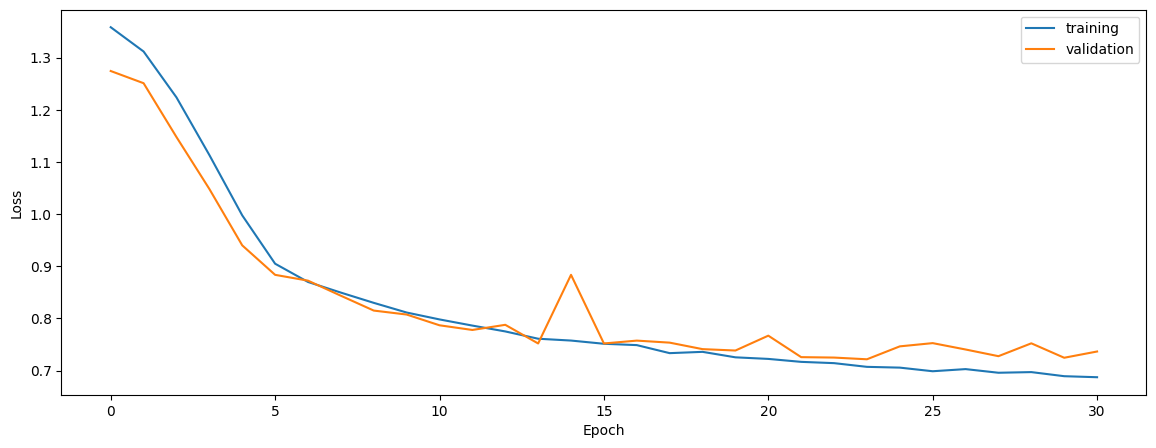

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


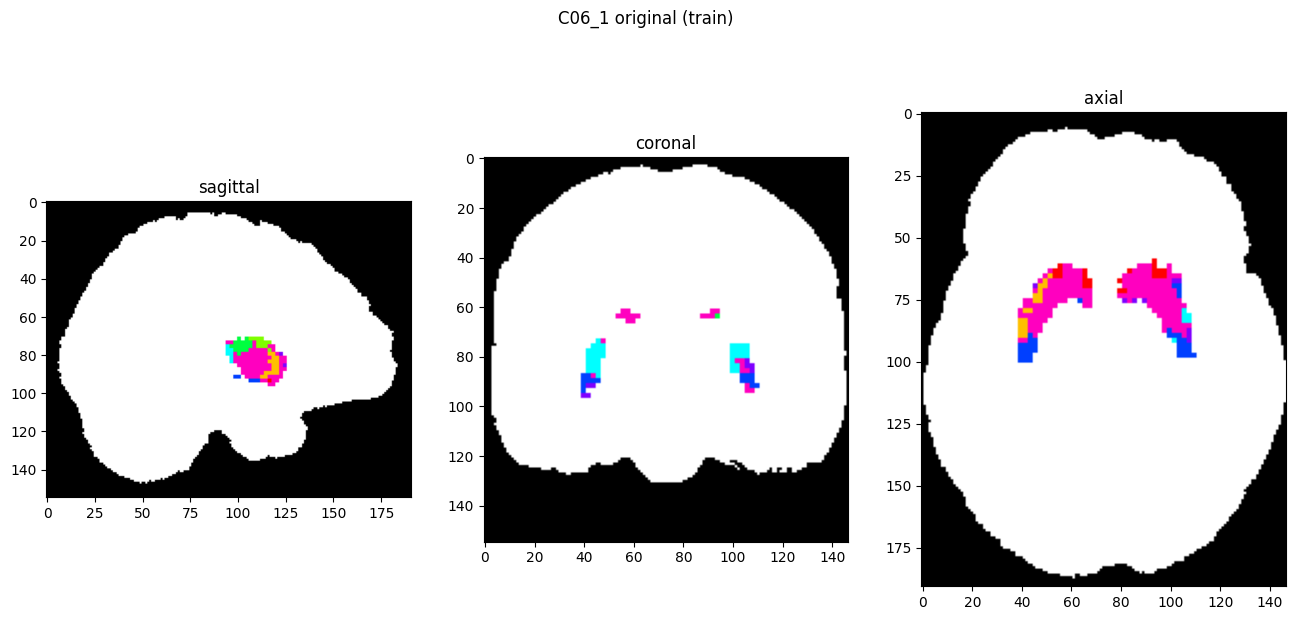

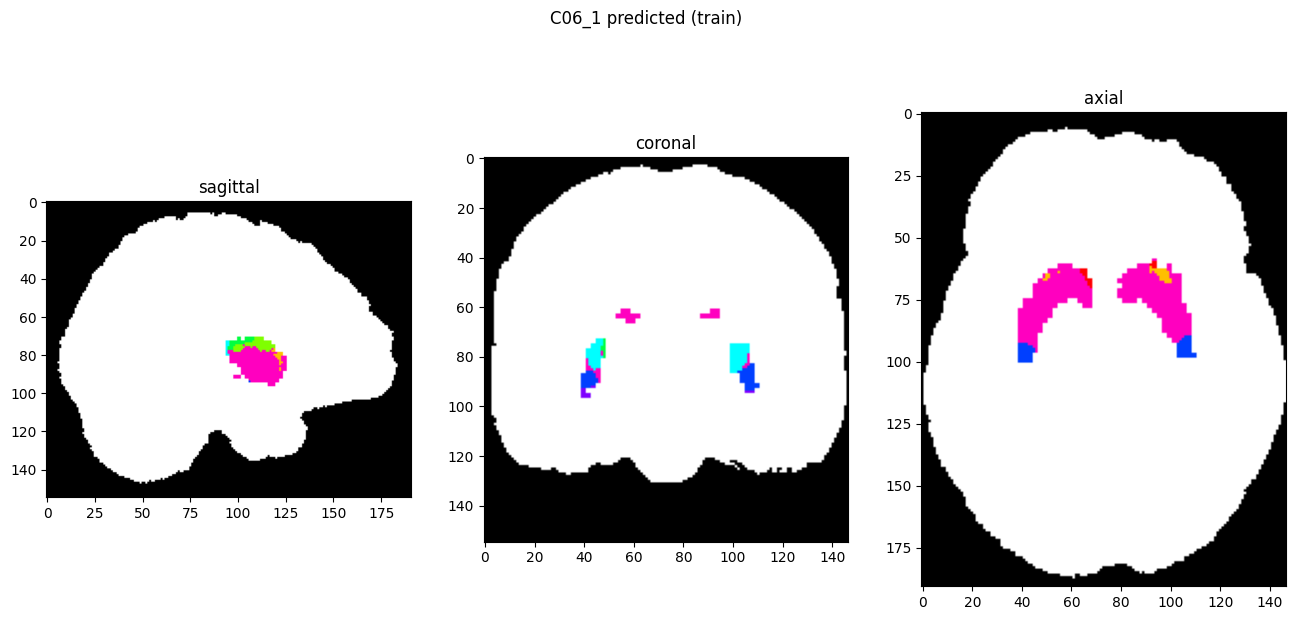

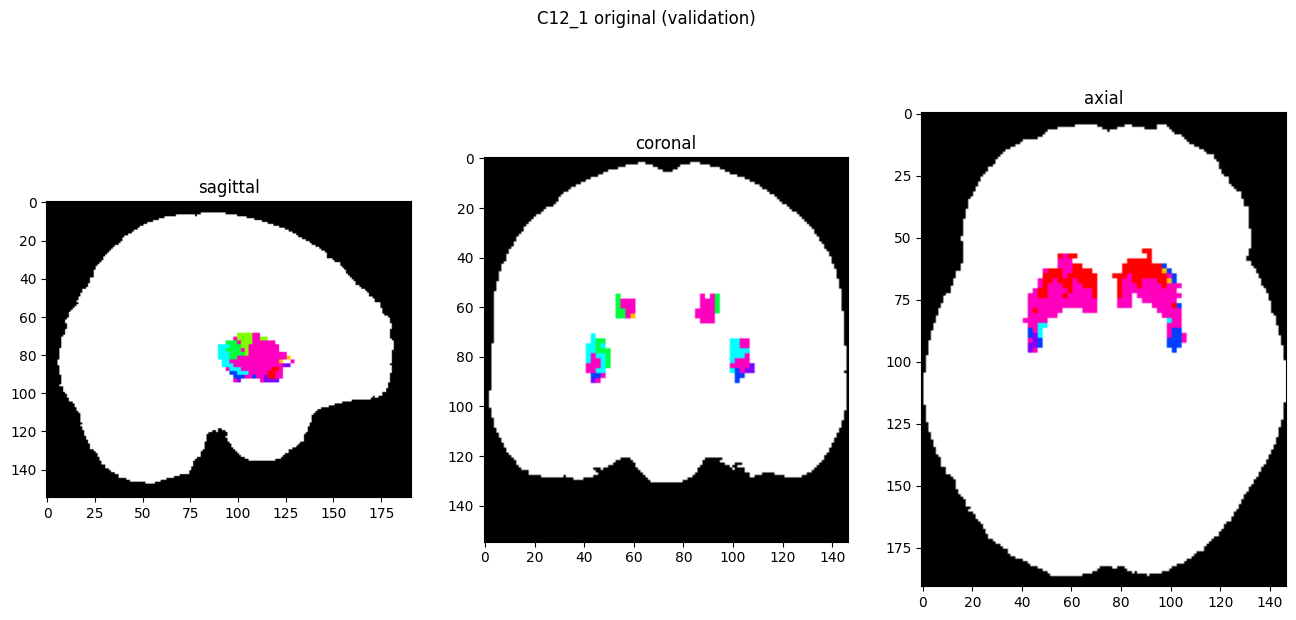

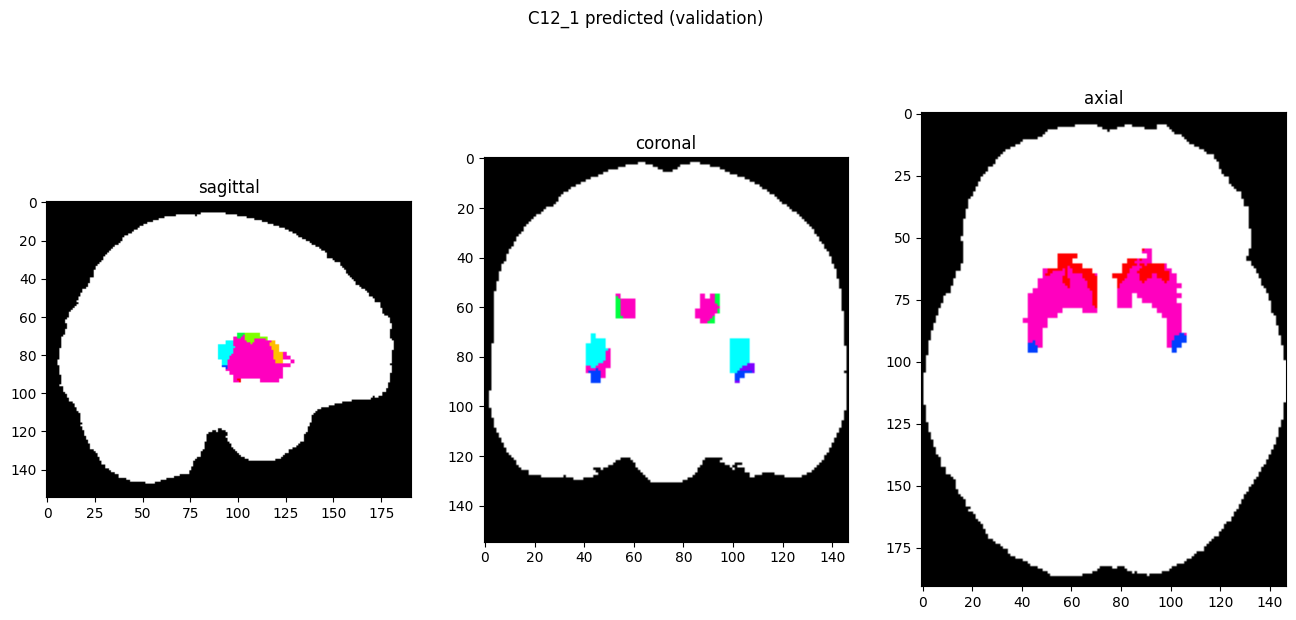

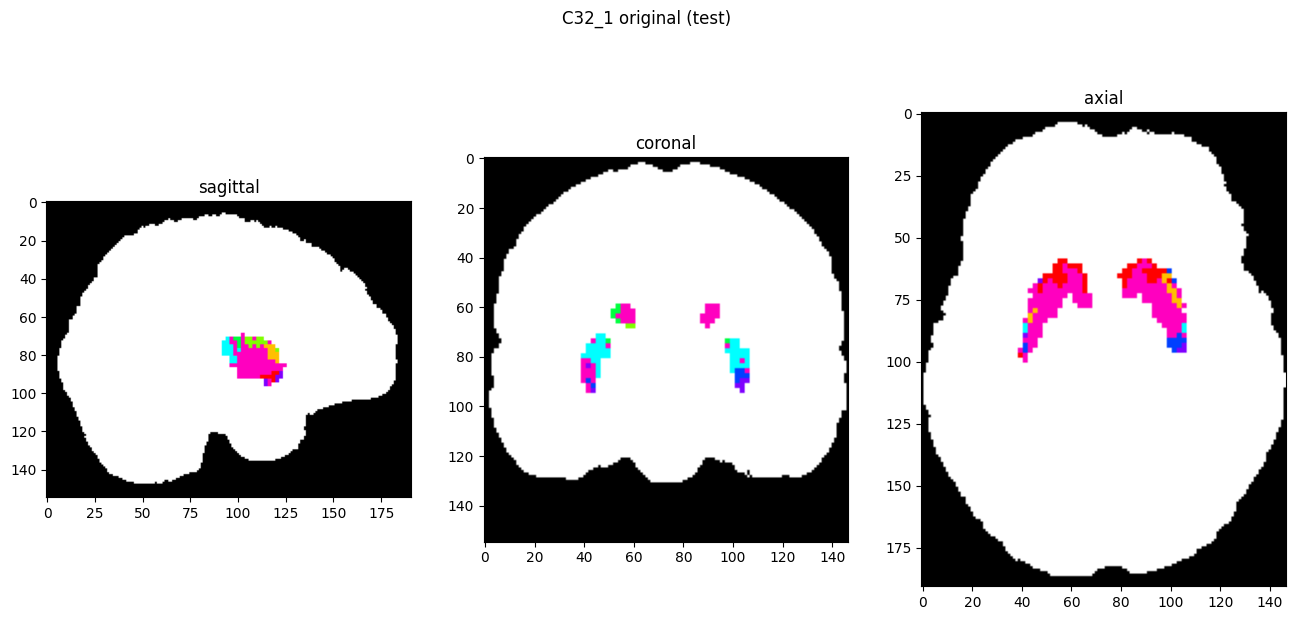

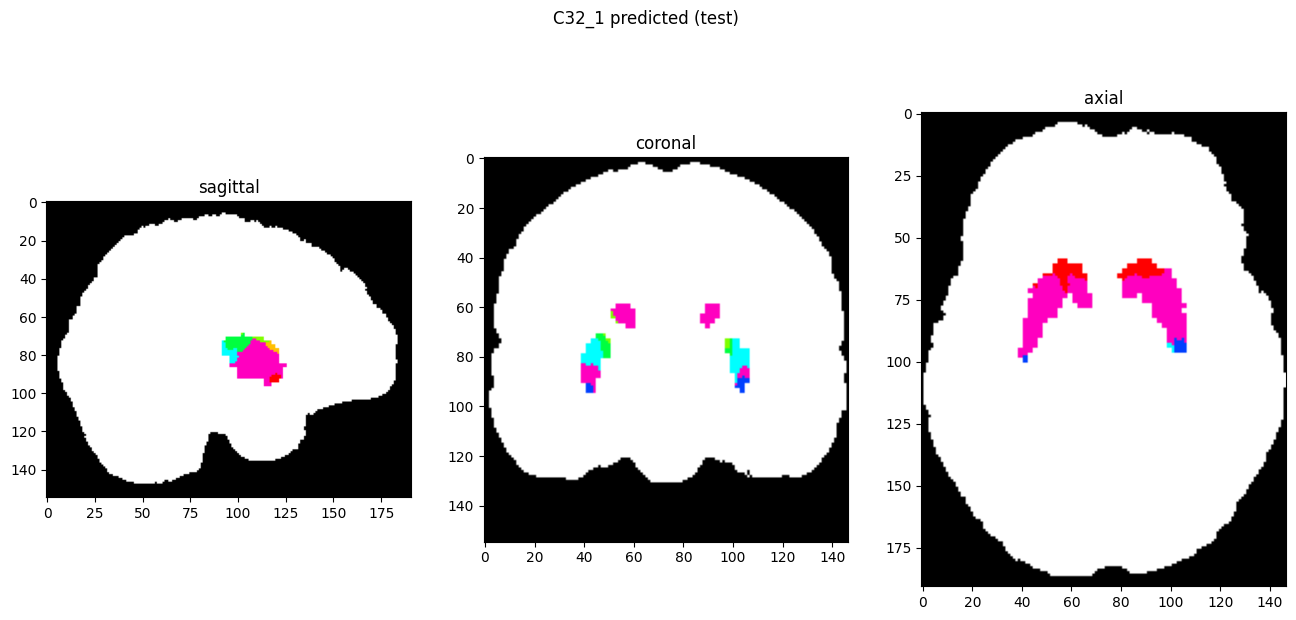

In [10]:
showResults(model, gen, threshold=0)